## Assignment : 14

<pre>
1. Preprocess all the Data we have in DonorsChoose <a href='https://drive.google.com/drive/folders/1MIwK7BQMev8f5CbDDVNLPaFGB32pFN60'>Dataset</a> use train.csv
2. Combine 4 essay's into one column named - 'preprocessed_essays'. 
3. After step 2 you have to train 3 types of models as discussed below. 
4. For all the model use <a href='https://scikit-learn.org/stable/modules/model_evaluation.html#roc-metrics'>'auc'</a> as a metric. check <a href='https://datascience.stackexchange.com/a/20192'>this</a> for using auc as a metric 
5. You are free to choose any number of layers/hiddden units but you have to use same type of architectures shown below. 
6. You can use any one of the optimizers and choice of Learning rate and momentum, resources: <a href='http://cs231n.github.io/neural-networks-3/'>cs231n class notes</a>, <a href='https://www.youtube.com/watch?v=hd_KFJ5ktUc'>cs231n class video</a>. 
7. For all the model's use <a href='https://www.youtube.com/watch?v=2U6Jl7oqRkM'>TensorBoard</a> and plot the Metric value and Loss with epoch. While submitting, take a screenshot of plots and include those images in .ipynb notebook and PDF. 
8. Use Categorical Cross Entropy as Loss to minimize.
</pre>

### Model-1

Build and Train deep neural network as shown below

<img src='https://i.imgur.com/w395Yk9.png'>
ref: https://i.imgur.com/w395Yk9.png

- __Input_seq_total_text_data__ --- You have to give Total text data columns. After this use the Embedding layer to get word vectors. Use given predefined glove word vectors, don't train any word vectors. After this use LSTM and get the LSTM output and Flatten that output. 
- __Input_school_state__ --- Give 'school_state' column as input to embedding layer and Train the Keras Embedding layer. 
- __Project_grade_category__  --- Give 'project_grade_category' column as input to embedding layer and Train the Keras Embedding layer.
- __Input_clean_categories__ --- Give 'input_clean_categories' column as input to embedding layer and Train the Keras Embedding layer.
- __Input_clean_subcategories__ --- Give 'input_clean_subcategories' column as input to embedding layer and Train the Keras Embedding layer.
- __Input_clean_subcategories__ --- Give 'input_teacher_prefix' column as input to embedding layer and Train the Keras Embedding layer.
- __Input_remaining_teacher_number_of_previously_posted_projects._resource_summary_contains_numerical_digits._price._quantity__ ---concatenate remaining columns and add a Dense layer after that. 



- For LSTM, you can choose your sequence padding methods on your own or you can train your LSTM without padding, there is no restriction on that.

Below is an example of embedding layer for a categorical columns. In below code all are dummy values, we gave only for referance. 

In [1]:
# https://stats.stackexchange.com/questions/270546/how-does-keras-embedding-layer-work
#input_layer = Input(shape=(n,))
#embedding = Embedding(no_1, no_2, input_length=n)(input_layer)
#flatten = Flatten()(embedding)

### 1. Go through this blog, if you have any doubt on using predefined Embedding values in Embedding layer - https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/
### 2. Please go through this link https://keras.io/getting-started/functional-api-guide/ and check the 'Multi-input and multi-output models' then you will get to know how to give multiple inputs. 

In [2]:
import pandas as pd
import numpy as np 
import os
import math
from collections import defaultdict
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import SpatialDropout1D, LSTM, BatchNormalization,concatenate,Flatten,Embedding,Dense,Dropout,MaxPooling2D,Reshape
from tensorflow.keras.models import Sequential
from tensorflow.keras import Model,Input
from tensorflow.keras.layers import Conv2D,Conv1D
import tensorflow.keras.backend as k
from sklearn.metrics import roc_auc_score
import tensorflow as tf
import keras
from sklearn.utils import compute_class_weight
from tensorflow.keras.initializers import he_normal,glorot_normal
from tensorflow.keras.regularizers import l1,l2
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint,LearningRateScheduler
from time import time
from tensorflow.python.keras.callbacks import TensorBoard
from IPython.display import SVG, display
import pickle 

import re

from nltk.corpus import stopwords
import pickle

from tqdm import tqdm
import os

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Preprocessing using reference_preprocessing file

In [4]:
project_data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/LSTM_donorsChoose/preprocessed_data.csv')

In [5]:
project_data.columns

Index(['school_state', 'teacher_prefix', 'project_grade_category',
       'teacher_number_of_previously_posted_projects', 'project_is_approved',
       'clean_categories', 'clean_subcategories', 'essay', 'price'],
      dtype='object')

In [6]:
project_data_original=project_data.copy()

In [7]:
Y=project_data["project_is_approved"].values

In [8]:
project_data.drop("project_is_approved",axis = 1, inplace = True)

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(project_data, Y, test_size=0.20, stratify=Y)

In [10]:
print(X_train.shape)
print(X_test.shape)

print(y_train.shape)
print(y_test.shape)

(87398, 8)
(21850, 8)
(87398,)
(21850,)


In [11]:
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train["essay"])
vocab_length = len(tokenizer.word_index) + 1

In [12]:
vocab_length

51624

In [13]:
import pickle
with open('/content/drive/My Drive/Colab Notebooks/LSTM_donorsChoose/glove_vectors', 'rb') as glove_vector:
    glove_vectors = pickle.load(glove_vector)
    glove_words =  set(glove_vectors.keys())

In [14]:
max_vocabulary = len(tokenizer.word_index)
embedding_matrix = np.zeros((max_vocabulary+1, 300))
for word, i in tokenizer.word_index.items():  
  if word in glove_words:    
    embedding_vector = glove_vectors[word]
    embedding_matrix[i] = embedding_vector


In [15]:
embedding_matrix[1]

array([ 1.5243e-01, -1.6945e-01, -2.2748e-02, -2.5051e-01, -1.5213e-01,
       -2.0300e-01, -3.3534e+00, -2.6162e-01,  1.2675e-01,  9.0183e-01,
        1.3074e-02,  3.7517e-01, -7.6090e-02, -6.2058e-01, -4.0122e-01,
       -6.7986e-02,  3.6276e-01, -1.9572e-01,  3.7641e-01, -4.7978e-02,
        6.5122e-03,  2.6432e-01, -5.2387e-02, -5.1525e-02, -3.0775e-01,
        6.3784e-02,  5.6517e-01, -2.2021e-01, -5.2199e-01, -3.5600e-01,
       -4.4535e-01, -6.5147e-01, -1.9593e-01,  3.2336e-01, -2.9516e-01,
        2.3886e-01, -1.8961e-01,  1.0907e-01, -2.4158e-01,  4.1535e-02,
        7.9857e-02,  4.4682e-02,  2.6472e-01, -6.6871e-01,  1.0028e-01,
       -4.5726e-01,  5.1603e-01,  3.8309e-02,  2.3472e-01, -2.4350e-01,
       -2.8054e-01,  2.9672e-01,  3.9380e-01,  2.5832e-01,  1.9966e-01,
       -3.8862e-01,  2.4473e-01,  3.6665e-01, -4.4643e-01,  5.4612e-02,
       -4.3967e-01,  2.8433e-01,  5.1575e-01, -2.0117e-01, -3.3626e-01,
        7.1260e-01,  3.3023e-02, -3.6070e-01,  7.8828e-01, -5.49

In [16]:
X_train['essay_tokens']  = tokenizer.texts_to_sequences(X_train['essay'].values)
X_test['essay_tokens']   = tokenizer.texts_to_sequences(X_test['essay'].values)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [17]:
from keras.preprocessing import sequence
max_review_length = 300
X_train_pad = sequence.pad_sequences(X_train['essay_tokens'].values, maxlen=max_review_length , padding='post' )
X_test_pad  = sequence.pad_sequences(X_test['essay_tokens'].values, maxlen=max_review_length , padding='post')

In [18]:
print(X_train_pad.shape)
print(X_train_pad[1])

(87398, 300)
[  208     2  2418     1  3133   889   792    14   324  1914    35     1
    20   627  1815  1914    29  3310   343   162   530  1861   165    14
   239   762   431   343    17   101  2847   333     9     1  1307  5065
   132    44    21   356    55     9    45   123  1220   294    43   125
  1430     5  1647     4   468  9293   152  2225  1399     2  1429    88
  9088    24   803  4518   280   719   202  4109   337  1568  3372     9
   152    85     5     9    19    16  2426   108     3  3506   637    25
     3   228  2966    83    44   612  2037   831   825   185    66    54
   294     1   123     1     4   468     8   993     1   108    48    12
   313    87   588   111  1937  3533  6096  2278    38    59    45    24
   572 12439 10736    62     9    24    19   347  2922  4818  1929  2278
    38  2351    45   367   100  2279     2  1028    53    22     3  2574
  1929   211  2725    12   313   195  1726  4643 19655  1312  9634   866
   374   507  2815   207 18411  3993  

In [19]:
from sklearn.preprocessing import LabelEncoder
labele = LabelEncoder()

labele.fit(project_data['school_state'].values)


X_train_school_state = labele.transform(X_train['school_state'].values)

X_test_school_state = labele.transform(X_test['school_state'].values)

In [20]:
import numpy as np
no_of_unique_states = X_train['school_state'].nunique()
embedding_size_school_state = min(np.ceil((no_of_unique_states)/2), 50 )
embedding_size_school_state = int(embedding_size_school_state)

In [21]:
print("Number of Unique School State:{}".format(no_of_unique_states))
print('Embedding Size: {}'.format(embedding_size_school_state))

Number of Unique School State:51
Embedding Size: 26


In [22]:
labele = LabelEncoder()
labele.fit(project_data['teacher_prefix'].values)
X_train_teacher_prefix = labele.transform(X_train['teacher_prefix'].values)
X_test_teacher_prefix = labele.transform(X_test['teacher_prefix'].values)

In [23]:
no_of_unique_teacher_prefix = X_train['teacher_prefix'].nunique()
embedding_size_teacher_prefix = min(np.ceil((no_of_unique_teacher_prefix)/2), 50 )
embedding_size_teacher_prefix = int(embedding_size_teacher_prefix)

In [24]:
print("Number of unique teacher_prefix= {}".format(no_of_unique_teacher_prefix))
print('Embedding size ={}'.format(embedding_size_teacher_prefix))

Number of unique teacher_prefix= 5
Embedding size =3


In [25]:
labele = LabelEncoder()
labele.fit(project_data['clean_categories'].values)
X_train_clean_categories = labele.transform(X_train['clean_categories'].values)
X_test_clean_categories = labele.transform(X_test['clean_categories'].values)

In [26]:
no_of_unique_clean_categories = X_train['clean_categories'].nunique()
embedding_size_clean_categories = min(np.ceil((no_of_unique_clean_categories)/2), 50 )
embedding_size_clean_categories = int(embedding_size_clean_categories)

In [27]:
print("Number of unique clean_categories= {}".format(no_of_unique_clean_categories))
print('Embedding size = {}'.format(embedding_size_clean_categories))

Number of unique clean_categories= 50
Embedding size = 25


In [28]:
project_data.columns

Index(['school_state', 'teacher_prefix', 'project_grade_category',
       'teacher_number_of_previously_posted_projects', 'clean_categories',
       'clean_subcategories', 'essay', 'price'],
      dtype='object')

In [29]:
labele.fit(project_data['clean_subcategories'].values)
X_train_clean_subcategories = labele.transform(X_train['clean_subcategories'].values)
X_test_clean_subcategories = labele.transform(X_test['clean_subcategories'].values)

In [30]:
no_of_unique_clean_subcategories = X_train['clean_subcategories'].nunique()
embedding_size_clean_subcategories = min(np.ceil((no_of_unique_clean_subcategories)/2), 50 )
embedding_size_clean_subcategories = int(embedding_size_clean_subcategories)

In [31]:
print("Number of unique clean_subcategories= {}".format(no_of_unique_clean_subcategories))
print('Embedding size = {}'.format(embedding_size_clean_subcategories))

Number of unique clean_subcategories= 392
Embedding size = 50


In [32]:
labele.fit(project_data['project_grade_category'].values)
X_train_project_grade_category = labele.transform(X_train['project_grade_category'].values)
X_test_project_grade_category = labele.transform(X_test['project_grade_category'].values)

In [33]:
no_of_unique_project_grade_category = X_train['project_grade_category'].nunique()
embedding_size_project_grade_category = min(np.ceil((no_of_unique_project_grade_category)/2), 50 )
embedding_size_project_grade_category = int(embedding_size_project_grade_category)

In [34]:
print("Number of unique project_grade_category= {}".format(no_of_unique_project_grade_category))
print('Embedding size = {}'.format(embedding_size_project_grade_category))

Number of unique project_grade_category= 4
Embedding size = 2


In [35]:
from sklearn.preprocessing import StandardScaler
Sscaler=StandardScaler()
Sscaler.fit(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))


train_num_projects=Sscaler.transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

test_num_projects=Sscaler.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

In [36]:
Sscaler.fit(X_train['price'].values.reshape(-1,1))

train_price = Sscaler.transform(X_train['price'].values.reshape(-1,1))

test_price = Sscaler.transform(X_test['price'].values.reshape(-1,1))

In [37]:
train_numeric_features = np.concatenate((train_num_projects , train_price) , axis = 1)

test_numeric_features= np.concatenate((test_num_projects , test_price) , axis = 1)



In [38]:
print(train_numeric_features.shape ,test_numeric_features.shape)

(87398, 2) (21850, 2)


In [39]:
def auc1( y_true, y_pred ) :
    score = tf.py_function( lambda y_true, y_pred : roc_auc_score( y_true, y_pred, average='macro', sample_weight=None).astype('float32'),
                        [y_true, y_pred],
                        'float32',
 )
    return score

#Model 1

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Embedding
from tensorflow.keras import regularizers
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense, Input , Dropout
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import TensorBoard

In [ ]:
max_vocabulary = len(tokenizer.word_index)
k_r=regularizers.l2(0.001)

In [ ]:
Text_input = Input(shape=(300,), name='Input_text')

X = Embedding(output_dim=300, input_dim=max_vocabulary+1, input_length=300 , weights=[embedding_matrix])(Text_input)
lstm_text = LSTM(100,recurrent_dropout=0.5,kernel_regularizer=k_r,return_sequences=True)(X)
flatten_1 = Flatten()(lstm_text)

In [ ]:
school_state_input = Input(shape=(1,), name='school_state')
X_school_state = Embedding(output_dim=embedding_size_school_state , input_dim=no_of_unique_states+1, input_length=1)(school_state_input)
flatten_2 = Flatten()(X_school_state)

In [ ]:
teacher_prefix_input = Input(shape=(1,), name='teacher_prefix')
X_teacher_prefix = Embedding(output_dim=embedding_size_teacher_prefix , input_dim=no_of_unique_teacher_prefix+1, input_length=1)(teacher_prefix_input)
flatten_3 = Flatten()(X_teacher_prefix)

In [ ]:
clean_categories_input = Input(shape=(1,), name='clean_categories')
X_clean_categories = Embedding(output_dim=embedding_size_clean_categories, input_dim=no_of_unique_clean_categories+2, input_length=1)(clean_categories_input)
flatten_4 = Flatten()(X_clean_categories)

In [ ]:
clean_subcategories_input = Input(shape=(1,), name='clean_subcategories')
X_clean_subcategories = Embedding(output_dim=embedding_size_clean_subcategories, input_dim=no_of_unique_clean_subcategories+15, input_length=1)(clean_subcategories_input)
flatten_5 = Flatten()(X_clean_subcategories)

In [ ]:
project_grade_category_input = Input(shape=(1,), name='project_grade_category')
X_project_grade_category = Embedding(output_dim=embedding_size_project_grade_category, input_dim=no_of_unique_project_grade_category+1, input_length=1)(project_grade_category_input)
flatten_6 = Flatten()(X_project_grade_category)


In [ ]:
numeric_features_input = Input(shape=(2,) , name="Remaining_feature")
numeric_dense = Dense(16, activation='relu' , kernel_initializer='he_normal',kernel_regularizer=l2(0.001))(numeric_features_input)

In [ ]:
X_concat = concatenate([flatten_1 , flatten_2 , flatten_3 ,flatten_4 , flatten_5 , flatten_6 , numeric_dense])

In [ ]:
model = Dense(200, activation="relu", kernel_initializer="he_normal" ,kernel_regularizer=k_r)(X_concat)

model = Dropout(0.5)(model)

model = Dense(128,activation="relu",kernel_initializer="glorot_normal" ,kernel_regularizer=regularizers.l2(0.001))(model)

model = BatchNormalization()(model)

model = Dropout(0.2)(model)

model = Dense(64,activation="relu", kernel_initializer="glorot_normal" ,kernel_regularizer=k_r)(model)


output = Dense(2, activation='softmax', name='output')(model)

model_1 = Model(inputs=[Text_input, school_state_input,teacher_prefix_input,clean_categories_input,
                       clean_subcategories_input,project_grade_category_input,numeric_features_input ],outputs=[output])


In [ ]:
model_1.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input_text (InputLayer)         [(None, 300)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 300, 300)     15492900    Input_text[0][0]                 
__________________________________________________________________________________________________
school_state (InputLayer)       [(None, 1)]          0                                            
__________________________________________________________________________________________________
teacher_prefix (InputLayer)     [(None, 1)]          0                                            
_______________________________________________________________________________________

In [ ]:
import datetime
checkpoint1 = ModelCheckpoint("/content/drive/My Drive/Colab Notebooks/LSTM_donorsChoose/Model/model_1.h5",
                             monitor="val_auc1",
                             mode="max",
                             save_best_only = True,
                             verbose=1)
earlystop1 = EarlyStopping(monitor = 'val_auc1', 
                            mode="max",
                            min_delta = 0, 
                            patience = 3,
                            verbose = 1)

log_dir="/content/drive/My Drive/Colab Notebooks/LSTM_donorsChoose/logs/Model1_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")


tensorboard1 = tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1)

callbacks_1 = [checkpoint1,earlystop1,tensorboard1]

In [ ]:
train_data = [X_train_pad,X_train_school_state,X_train_teacher_prefix,X_train_clean_categories,X_train_clean_subcategories,X_train_project_grade_category,train_numeric_features]

test_data = [X_test_pad,X_test_school_state,X_test_teacher_prefix,X_test_clean_categories,X_test_clean_subcategories,X_test_project_grade_category,test_numeric_features]

In [ ]:
from keras.utils import np_utils

y_train = np_utils.to_categorical(y_train, 2) 
y_test = np_utils.to_categorical(y_test, 2)

In [ ]:
model_1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[auc1])
history = model_1.fit(train_data, y_train, batch_size=512, epochs=10, verbose=1,callbacks=callbacks_1, validation_data=(test_data, y_test))

Epoch 1/10
  1/171 [..............................] - ETA: 0s - loss: 2.4039 - auc1: 0.4489WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
171/171 [==============================] - ETA: 0s - loss: 0.9581 - auc1: 0.5769
Epoch 00001: val_auc1 improved from -inf to 0.71892, saving model to /content/drive/My Drive/Colab Notebooks/LSTM_donorsChoose/Model/model_1.h5
171/171 [==============================] - 1133s 7s/step - loss: 0.9581 - auc1: 0.5769 - val_loss: 0.7951 - val_auc1: 0.7189
Epoch 2/10
171/171 [==============================] - ETA: 0s - loss: 0.5435 - auc1: 0.7324
Epoch 00002: val_auc1 improved from 0.71892 to 0.75371, saving model to /content/drive/My Drive/Colab Notebooks/LSTM_donorsChoose/Model/model_1.h5
171/171 [==============================] -

In [ ]:
model_1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[auc1])
model_1.load_weights("/content/drive/My Drive/Colab Notebooks/LSTM_donorsChoose/Model/model_1.h5")

In [ ]:
print("AUC for test Data:",roc_auc_score(y_test,model_1.predict(test_data)))

AUC for test Data: 0.7535854008097176


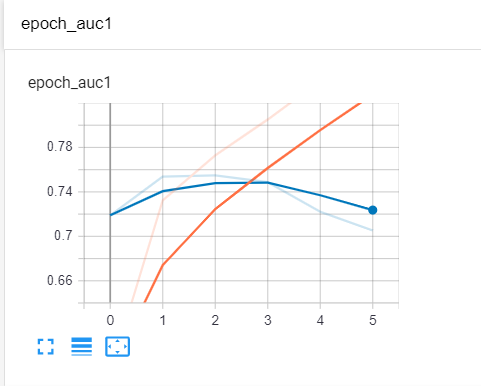

In [1]:
from PIL import Image
Image.open("model_1_1.png")

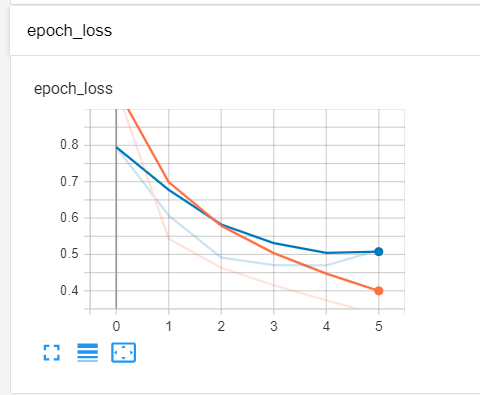

In [2]:
Image.open("model_1_2.png")

The model we build was able to predict output correctly but after few epochs its started overfitting. In next model, we will try to clean some text data to check the performance on the same model.

### Model-2

Use the same model as above but for 'input_seq_total_text_data' give only some words in the sentance not all the words. Filter the words as below. 

<pre>
1. Train the TF-IDF on the Train data <br>
2. Get the idf value for each word we have in the train data. <br>
3. Remove the low idf value and high idf value words from our data. Do some analysis on the Idf values and based on those values choose the low and high threshold value. Because very frequent words and very very rare words don't give much information. (you can plot a box plots and take only the idf scores within IQR range and corresponding words)<br>
4. Train the LSTM after removing the Low and High idf value words. (In model-1 Train on total data but in Model-2 train on data after removing some words based on IDF values)
</pre>

Text(0, 0.5, 'IDF score')

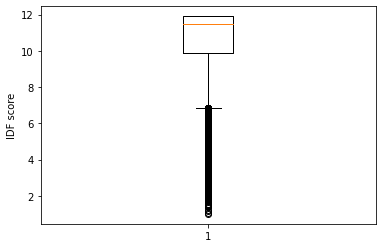

In [41]:
tfidf = TfidfVectorizer()
data_text = tfidf.fit_transform(project_data['essay'].values)
plt.boxplot(tfidf.idf_)
plt.ylabel("IDF score")

In [42]:
for i in range(0,101,10):
  print("The {}th percentile of idf score is :{}".format(i,np.percentile(tfidf.idf_,[i])))


The 0th percentile of idf score is :[1.00770934]
The 10th percentile of idf score is :[7.77307122]
The 20th percentile of idf score is :[9.34328842]
The 30th percentile of idf score is :[10.29879987]
The 40th percentile of idf score is :[10.99194705]
The 50th percentile of idf score is :[11.50277267]
The 60th percentile of idf score is :[11.50277267]
The 70th percentile of idf score is :[11.90823778]
The 80th percentile of idf score is :[11.90823778]
The 90th percentile of idf score is :[11.90823778]
The 100th percentile of idf score is :[11.90823778]


In [43]:
idf_scores = tfidf.idf_
filtered_indices = np.argwhere(((idf_scores> 7.77307122) & (idf_scores<11.90823778 ) ))
filtered_indices = [idx[0] for idx in filtered_indices]

In [44]:
vocabulary = tfidf.get_feature_names()
filtered_voc = {vocabulary[i] for i in filtered_indices}

In [45]:
processed_text = []
for text in project_data["essay"].values:
  text_word_list = [word for word in text.split() if word in filtered_voc]
  processed_text.append(' '.join(text_word_list))

In [46]:
len(processed_text)

109248

In [47]:
project_data["processed_essay"]=processed_text

In [48]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(project_data, Y, test_size=0.20, stratify=Y)

In [49]:
print(X_train.shape)
print(X_test.shape)

print(y_train.shape)
print(y_test.shape)

(87398, 9)
(21850, 9)
(87398,)
(21850,)


In [50]:
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words= 100000 )
tokenizer.fit_on_texts(X_train["processed_essay"])

In [51]:
X_train['processed_essay_tokens']  = tokenizer.texts_to_sequences(X_train['processed_essay'].values)
X_test['processed_essay_tokens']   = tokenizer.texts_to_sequences(X_test['processed_essay'].values)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [52]:
from keras.preprocessing import sequence
max_review_length = 300
X_train_pad = sequence.pad_sequences(X_train['processed_essay_tokens'].values, maxlen=max_review_length , padding='post' )
X_test_pad  = sequence.pad_sequences(X_test['processed_essay_tokens'].values, maxlen=max_review_length , padding='post')

In [53]:
print(X_train_pad.shape)


(87398, 300)


In [54]:
import pickle
with open('/content/drive/My Drive/Colab Notebooks/LSTM_donorsChoose/glove_vectors', 'rb') as glove_vector:
    glove_vectors = pickle.load(glove_vector)
    glove_words =  set(glove_vectors.keys())

In [55]:
max_vocabulary = len(tokenizer.word_index)
embedding_matrix = np.zeros((max_vocabulary+1, 300))
for word, i in tokenizer.word_index.items():  
  if word in glove_words:    
    embedding_vector = glove_vectors[word]
    embedding_matrix[i] = embedding_vector


In [56]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Embedding
from tensorflow.keras import regularizers
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense, Input , Dropout
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import TensorBoard

In [57]:
max_vocabulary = len(tokenizer.word_index)
k_r=regularizers.l2(0.001)

In [58]:
Text_input = Input(shape=(300,), name='Input_text')

X = Embedding(output_dim=300, input_dim=max_vocabulary+1, input_length=300 , weights=[embedding_matrix])(Text_input)
lstm_text = LSTM(100,recurrent_dropout=0.5,kernel_regularizer=k_r,return_sequences=True)(X)
flatten_1 = Flatten()(lstm_text)

In [59]:
school_state_input = Input(shape=(1,), name='school_state')
X_school_state = Embedding(output_dim=embedding_size_school_state , input_dim=no_of_unique_states+1, input_length=1)(school_state_input)
flatten_2 = Flatten()(X_school_state)

In [60]:
teacher_prefix_input = Input(shape=(1,), name='teacher_prefix')
X_teacher_prefix = Embedding(output_dim=embedding_size_teacher_prefix , input_dim=no_of_unique_teacher_prefix+1, input_length=1)(teacher_prefix_input)
flatten_3 = Flatten()(X_teacher_prefix)

In [61]:
clean_categories_input = Input(shape=(1,), name='clean_categories')
X_clean_categories = Embedding(output_dim=embedding_size_clean_categories, input_dim=no_of_unique_clean_categories+2, input_length=1)(clean_categories_input)
flatten_4 = Flatten()(X_clean_categories)

In [62]:
clean_subcategories_input = Input(shape=(1,), name='clean_subcategories')
X_clean_subcategories = Embedding(output_dim=embedding_size_clean_subcategories, input_dim=no_of_unique_clean_subcategories+15, input_length=1)(clean_subcategories_input)
flatten_5 = Flatten()(X_clean_subcategories)

In [63]:
project_grade_category_input = Input(shape=(1,), name='project_grade_category')
X_project_grade_category = Embedding(output_dim=embedding_size_project_grade_category, input_dim=no_of_unique_project_grade_category+1, input_length=1)(project_grade_category_input)
flatten_6 = Flatten()(X_project_grade_category)


In [64]:
numeric_features_input = Input(shape=(2,) , name="Numeric_feature")
numeric_dense = Dense(16, activation='relu' , kernel_initializer='he_normal',kernel_regularizer=l2(0.001))(numeric_features_input)

In [65]:
X_concat = concatenate([flatten_1 , flatten_2 , flatten_3 ,flatten_4 , flatten_5 , flatten_6 , numeric_dense])

In [66]:
model = Dense(200, activation="relu", kernel_initializer="he_normal" ,kernel_regularizer=k_r)(X_concat)

model = Dropout(0.5)(model)

model = Dense(128,activation="relu",kernel_initializer="glorot_normal" ,kernel_regularizer=regularizers.l2(0.001))(model)

model = BatchNormalization()(model)

model = Dropout(0.5)(model)

model = Dense(64,activation="relu", kernel_initializer="glorot_normal" ,kernel_regularizer=k_r)(model)


output = Dense(2, activation='softmax', name='output')(model)

model_2 = Model(inputs=[Text_input, school_state_input,teacher_prefix_input,clean_categories_input,
                       clean_subcategories_input,project_grade_category_input,numeric_features_input ],outputs=[output])


In [67]:
model_2.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input_text (InputLayer)         [(None, 300)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 300, 300)     15487800    Input_text[0][0]                 
__________________________________________________________________________________________________
school_state (InputLayer)       [(None, 1)]          0                                            
__________________________________________________________________________________________________
teacher_prefix (InputLayer)     [(None, 1)]          0                                            
_______________________________________________________________________________________

In [68]:
import datetime
checkpoint1 = ModelCheckpoint("/content/drive/My Drive/Colab Notebooks/LSTM_donorsChoose/Model/model_2.h5",
                             monitor="val_auc1",
                             mode="max",
                             save_best_only = True,
                             verbose=1)
earlystop1 = EarlyStopping(monitor = 'val_auc1', 
                            mode="max",
                            min_delta = 0, 
                            patience = 3,
                            verbose = 1)

log_dir="/content/drive/My Drive/Colab Notebooks/LSTM_donorsChoose/logs/Model2_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")


tensorboard1 = tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1)

callbacks_1 = [checkpoint1,
               earlystop1,
               tensorboard1]

In [69]:
train_data = [X_train_pad,X_train_school_state,X_train_teacher_prefix,X_train_clean_categories,X_train_clean_subcategories,X_train_project_grade_category,train_numeric_features]

test_data = [X_test_pad,X_test_school_state,X_test_teacher_prefix,X_test_clean_categories,X_test_clean_subcategories,X_test_project_grade_category,test_numeric_features]

In [70]:
from keras.utils import np_utils

y_train = np_utils.to_categorical(y_train, 2) 
y_test = np_utils.to_categorical(y_test, 2)

In [71]:
model_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[auc1])
history = model_2.fit(train_data, y_train, batch_size=128, epochs=15, verbose=1,callbacks=callbacks_1, validation_data=(test_data, y_test))

Epoch 1/15
  1/683 [..............................] - ETA: 0s - loss: 1.6493 - auc1: 0.5321WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
683/683 [==============================] - ETA: 0s - loss: 0.7131 - auc1: 0.6641
Epoch 00001: val_auc1 improved from -inf to 0.73674, saving model to /content/drive/My Drive/Colab Notebooks/LSTM_donorsChoose/Model/model_2.h5
683/683 [==============================] - 1596s 2s/step - loss: 0.7131 - auc1: 0.6641 - val_loss: 0.6256 - val_auc1: 0.7367
Epoch 2/15
683/683 [==============================] - ETA: 0s - loss: 0.4840 - auc1: 0.7535
Epoch 00002: val_auc1 improved from 0.73674 to 0.73882, saving model to /content/drive/My Drive/Colab Notebooks/LSTM_donorsChoose/Model/model_2.h5
683/683 [==============================] -

In [72]:
model_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[auc1])
model_2.load_weights("/content/drive/My Drive/Colab Notebooks/LSTM_donorsChoose/Model/model_2.h5")

In [73]:
print("AUC for test Data:",roc_auc_score(y_test,model_2.predict(test_data)))

AUC for test Data: 0.7385366461735225


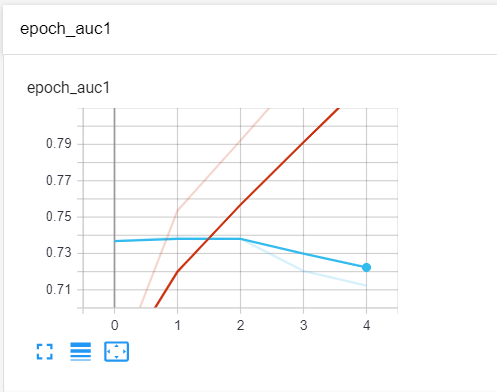

In [3]:
Image.open("model_2_1.png")

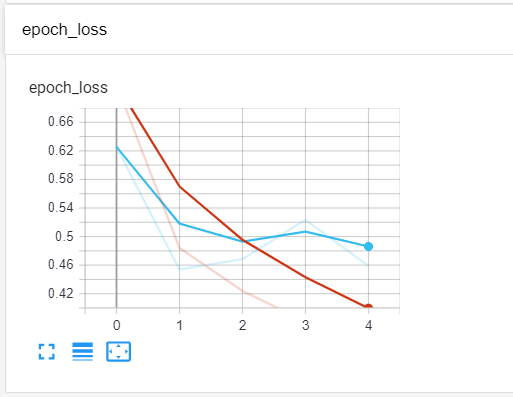

In [4]:
Image.open("model_2_2.png")

After removing common and some rearly used words, we can see that the model accurecy has increased in first 2 epochs. But like the previous model, it started getting overfitting. But removing the common words and some rearly used words, does have an impact of model performance.

### Model-3

<img src='https://i.imgur.com/fkQ8nGo.png'>
ref: https://i.imgur.com/fkQ8nGo.png


- __input_seq_total_text_data__: <br>
<pre>
    . Use text column('essay'), and use the Embedding layer to get word vectors. <br>
    . Use given predefined glove word vectors, don't train any word vectors. <br>
    . Use LSTM that is given above, get the LSTM output and Flatten that output. <br>
    . You are free to preprocess the input text as you needed. <br>
</pre>
- __Other_than_text_data__:<br>
<pre>
    . Convert all your Categorical values to onehot coded and then concatenate all these onehot vectors <br>
    . Neumerical values and use <a href='https://keras.io/getting-started/sequential-model-guide/#sequence-classification-with-1d-convolutions'>CNN1D</a> as shown in above figure. <br>
    . You are free to choose all CNN parameters like kernel sizes, stride.<br>
    
</pre>

In [40]:
from scipy.sparse import hstack
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Embedding
from tensorflow.keras import regularizers
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense, Input , Dropout
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import TensorBoard

In [41]:
project_data=project_data_original.copy()

In [42]:
Y=project_data["project_is_approved"].values

In [43]:
project_data.drop("project_is_approved",axis = 1, inplace = True)

In [44]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(project_data, Y, test_size=0.25, stratify=Y)

In [45]:
print(X_train.shape)
print(X_test.shape)

print(y_train.shape)
print(y_test.shape)

(81936, 8)
(27312, 8)
(81936,)
(27312,)


In [46]:
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words= 100000 )
tokenizer.fit_on_texts(X_train["essay"])

In [47]:
X_train['essay_tokens']  = tokenizer.texts_to_sequences(X_train['essay'].values)
X_test['essay_tokens']   = tokenizer.texts_to_sequences(X_test['essay'].values)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [48]:
from keras.preprocessing import sequence
max_review_length = 300
X_train_pad = sequence.pad_sequences(X_train['essay_tokens'].values, maxlen=max_review_length , padding='post' )
X_test_pad  = sequence.pad_sequences(X_test['essay_tokens'].values, maxlen=max_review_length , padding='post')

In [49]:
print(X_train_pad.shape)
print(X_train_pad[1])

(81936, 300)
[ 2649     2   124    77  1703   112   185     3   375     8  1423   332
     1   378     3   324  1002  5013    91   134    51   133   798     4
     1   600   126     6   808   453 14881   253   126     2   186   587
    16   521   386   143   216     1     4     1   100   691    54  1795
    16  2029   670   813   216   342     2   103   972  1233   405   790
     2   236   123   222    48   478   867   160     2 22964  2195   124
    77  1411   143   326  1483   299   468    70   249    57  3247    79
  1645  1277   155   147     1   242  2552    19   222  2034    33   623
   163   160    44    20     4     1   203    12   126   115    33   790
     7   124   153   119   962    43    87   570  1010   119  1211   137
    69   222   326  1483    16   356   160    16   108   146   742   593
   622 16996  4245  2619  2650  1450   557   359  2600    34    22   124
   153   637    99     2  1008   478     1  1163   191   461   926   321
  1316  1163  4989   596   530  1250  

In [50]:
import pickle
with open('/content/drive/My Drive/Colab Notebooks/LSTM_donorsChoose/glove_vectors', 'rb') as glove_vector:
    glove_vectors = pickle.load(glove_vector)
    glove_words =  set(glove_vectors.keys())

In [51]:
max_vocabulary = len(tokenizer.word_index)
embedding_matrix = np.zeros((max_vocabulary+1, 300))
for word, i in tokenizer.word_index.items():  
  if word in glove_words:    
    embedding_vector = glove_vectors[word]
    embedding_matrix[i] = embedding_vector


In [52]:
embedding_matrix[1]

array([ 1.5243e-01, -1.6945e-01, -2.2748e-02, -2.5051e-01, -1.5213e-01,
       -2.0300e-01, -3.3534e+00, -2.6162e-01,  1.2675e-01,  9.0183e-01,
        1.3074e-02,  3.7517e-01, -7.6090e-02, -6.2058e-01, -4.0122e-01,
       -6.7986e-02,  3.6276e-01, -1.9572e-01,  3.7641e-01, -4.7978e-02,
        6.5122e-03,  2.6432e-01, -5.2387e-02, -5.1525e-02, -3.0775e-01,
        6.3784e-02,  5.6517e-01, -2.2021e-01, -5.2199e-01, -3.5600e-01,
       -4.4535e-01, -6.5147e-01, -1.9593e-01,  3.2336e-01, -2.9516e-01,
        2.3886e-01, -1.8961e-01,  1.0907e-01, -2.4158e-01,  4.1535e-02,
        7.9857e-02,  4.4682e-02,  2.6472e-01, -6.6871e-01,  1.0028e-01,
       -4.5726e-01,  5.1603e-01,  3.8309e-02,  2.3472e-01, -2.4350e-01,
       -2.8054e-01,  2.9672e-01,  3.9380e-01,  2.5832e-01,  1.9966e-01,
       -3.8862e-01,  2.4473e-01,  3.6665e-01, -4.4643e-01,  5.4612e-02,
       -4.3967e-01,  2.8433e-01,  5.1575e-01, -2.0117e-01, -3.3626e-01,
        7.1260e-01,  3.3023e-02, -3.6070e-01,  7.8828e-01, -5.49

In [53]:
vectorizer = CountVectorizer()
#vectorizer.fit(X_train['school_state'].values)
x_train_state_onehot = vectorizer.fit_transform(X_train['school_state'].values)
x_test_state_onehot = vectorizer.transform(X_test['school_state'].values)



print(x_train_state_onehot.shape, y_train.shape)
print(x_test_state_onehot.shape, y_test.shape)

(81936, 51) (81936,)
(27312, 51) (27312,)


In [54]:
X_train.columns

Index(['school_state', 'teacher_prefix', 'project_grade_category',
       'teacher_number_of_previously_posted_projects', 'clean_categories',
       'clean_subcategories', 'essay', 'price', 'essay_tokens'],
      dtype='object')

In [55]:
vectorizer = CountVectorizer()
#vectorizer.fit(X_train['project_subject_categories'].values)

x_train_categories_onehot = vectorizer.fit_transform(X_train['clean_categories'].values)
x_test_categories_onehot = vectorizer.transform(X_test['clean_categories'].values)

print(x_train_categories_onehot.shape, y_train.shape)
print(x_test_categories_onehot.shape, y_test.shape)

(81936, 9) (81936,)
(27312, 9) (27312,)


In [56]:
vectorizer = CountVectorizer()
#vectorizer.fit(X_train['project_subject_subcategories'].values)

x_train_subcategories_onehot = vectorizer.fit_transform(X_train['clean_subcategories'].values)
x_test_subcategories_onehot = vectorizer.transform(X_test['clean_subcategories'].values)

print(x_train_subcategories_onehot.shape, y_train.shape)
print(x_test_subcategories_onehot.shape, y_test.shape)

(81936, 30) (81936,)
(27312, 30) (27312,)


In [57]:
vectorizer = CountVectorizer()
#vectorizer.fit(X_train['teacher_prefix'].values)
x_train_teacher_prefix_onehot = vectorizer.fit_transform(X_train['teacher_prefix'].values)
x_test_teacher_prefix_onehot = vectorizer.transform(X_test['teacher_prefix'].values)

print(x_train_teacher_prefix_onehot.shape, y_train.shape)
print(x_test_teacher_prefix_onehot.shape, y_test.shape)

(81936, 5) (81936,)
(27312, 5) (27312,)


In [58]:
vectorizer = CountVectorizer()
#vectorizer.fit(X_train['project_grade_category'].values)
x_train_project_grade_onehot = vectorizer.fit_transform(X_train['project_grade_category'].values)
x_test_project_grade_onehot = vectorizer.transform(X_test['project_grade_category'].values)


print(x_train_project_grade_onehot.shape, y_train.shape)
print(x_test_project_grade_onehot.shape, y_test.shape)

(81936, 4) (81936,)
(27312, 4) (27312,)


In [59]:
X_train.columns

Index(['school_state', 'teacher_prefix', 'project_grade_category',
       'teacher_number_of_previously_posted_projects', 'clean_categories',
       'clean_subcategories', 'essay', 'price', 'essay_tokens'],
      dtype='object')

In [60]:
x_train_previously_posted_projects = X_train["teacher_number_of_previously_posted_projects"].values
x_train_previously_posted_projects = x_train_previously_posted_projects.reshape(81936, 1)

x_test_previously_posted_projects = X_test["teacher_number_of_previously_posted_projects"].values
x_test_previously_posted_projects = x_test_previously_posted_projects.reshape(27312, 1)
print(x_train_previously_posted_projects.shape, x_test_previously_posted_projects.shape)

(81936, 1) (27312, 1)


In [61]:
cat_feature_train = hstack((x_train_state_onehot,x_train_project_grade_onehot,x_train_categories_onehot,x_train_subcategories_onehot,x_train_teacher_prefix_onehot,x_train_previously_posted_projects))
cat_feature_test = hstack((x_test_state_onehot,x_test_project_grade_onehot,x_test_categories_onehot,x_test_subcategories_onehot,x_test_teacher_prefix_onehot,x_test_previously_posted_projects))

In [62]:
cat_feature_train=cat_feature_train.todense()
cat_feature_test=cat_feature_test.todense()

In [63]:
print(cat_feature_train.shape, cat_feature_test.shape)

(81936, 100) (27312, 100)


In [64]:
rest_features_train = np.array(cat_feature_train).reshape(cat_feature_train.shape[0],cat_feature_train.shape[1],1)
rest_features_test = np.array(cat_feature_test).reshape(cat_feature_test.shape[0],cat_feature_test.shape[1],1)

In [65]:
print(rest_features_train.shape, rest_features_test.shape)

(81936, 100, 1) (27312, 100, 1)


In [66]:
from keras.utils import np_utils

y_train = np_utils.to_categorical(y_train, 2) 
y_test = np_utils.to_categorical(y_test, 2)

In [67]:
print(y_train.shape)
print(y_test.shape)

(81936, 2)
(27312, 2)


In [68]:
essay = Input(shape=(300,), name='essay_input')

X = Embedding(output_dim=300, input_dim=max_vocabulary+1, input_length=300 , weights=[embedding_matrix])(essay)
lstm_essay = LSTM(100,recurrent_dropout=0.5,kernel_regularizer=regularizers.l2(0.001),return_sequences=True)(X)
flatten_1 = Flatten()(lstm_essay)

In [69]:
input_without_text  = Input(shape=(100,1), name='without_text')

convo = Conv1D(filters=128, kernel_size=3, strides=1)(input_without_text)

convo = Conv1D(filters=64, kernel_size=3, strides=1)(convo)

flatten_without_text = Flatten()(convo)

In [70]:
x_concat = concatenate([flatten_1  , flatten_without_text])

In [71]:
x = Dense(120, activation="relu", kernel_initializer="he_normal" ,kernel_regularizer=regularizers.l2(0.001))(x_concat)

x=Dropout(0.5)(x)

x = Dense(64,activation="sigmoid",kernel_initializer="glorot_normal" ,kernel_regularizer=regularizers.l2(0.001))(x)

x = BatchNormalization()(x)

x=Dropout(0.5)(x)

x = Dense(32,activation="relu", kernel_initializer="he_normal" ,kernel_regularizer=regularizers.l2(0.001))(x)

x=Dropout(0.6)(x)

output = Dense(2, activation='softmax', name='output')(x)


In [72]:


model_3 = Model(inputs=[essay, input_without_text],outputs=[output])



print(model_3.summary())

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
essay_input (InputLayer)        [(None, 300)]        0                                            
__________________________________________________________________________________________________
without_text (InputLayer)       [(None, 100, 1)]     0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 300, 300)     15136500    essay_input[0][0]                
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 98, 128)      512         without_text[0][0]               
_______________________________________________________________________________________

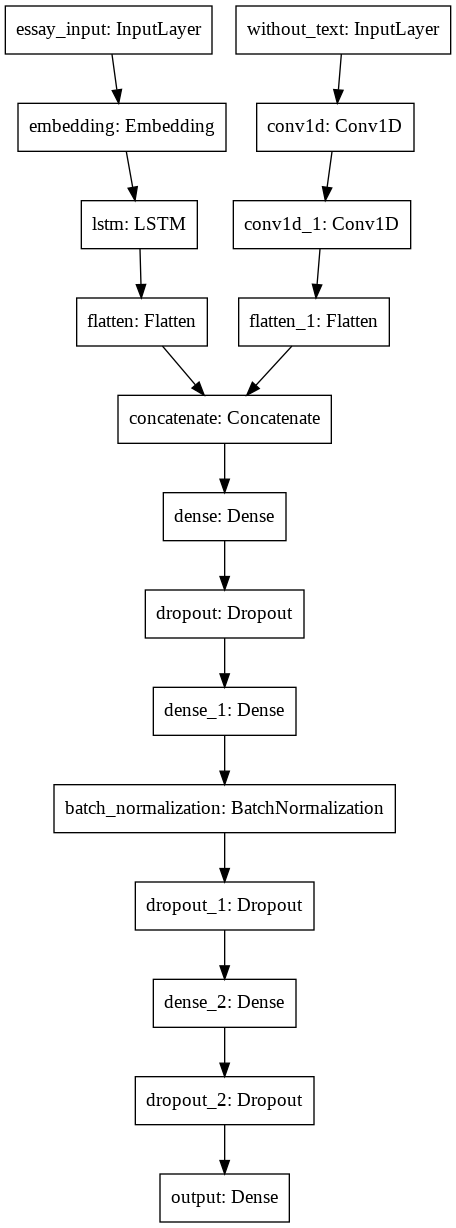

In [73]:
tf.keras.utils.plot_model(
    model_3, to_file='model.png', show_shapes=False, show_layer_names=True,
    rankdir='TB', expand_nested=False, dpi=96
)

In [74]:
import datetime
checkpoint1 = ModelCheckpoint("/content/drive/My Drive/Colab Notebooks/LSTM_donorsChoose/Model/model_3.h5",
                             monitor="val_auc1",
                             mode="max",
                             save_best_only = True,
                             verbose=1)
earlystop1 = EarlyStopping(monitor = 'val_auc1', 
                            mode="max",
                            min_delta = 0, 
                            patience = 3,
                            verbose = 1)

log_dir="/content/drive/My Drive/Colab Notebooks/LSTM_donorsChoose/logs/Model3_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")


tensorboard1 = tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1)

callbacks_1 = [checkpoint1,
               earlystop1,
               tensorboard1]

In [75]:
train_dataset = [X_train_pad,rest_features_train]
test_dataset = [X_test_pad,rest_features_test]

model_3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[auc1])
history_3= model_3.fit([X_train_pad,rest_features_train], y_train, batch_size=512, epochs=15, verbose=1,callbacks=callbacks_1, validation_data=(test_dataset, y_test))

Epoch 1/15
  1/161 [..............................] - ETA: 0s - loss: 1.7836 - auc1: 0.5641WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
161/161 [==============================] - ETA: 0s - loss: 1.1142 - auc1: 0.5370
Epoch 00001: val_auc1 improved from -inf to 0.69483, saving model to /content/drive/My Drive/Colab Notebooks/LSTM_donorsChoose/Model/model_3.h5
161/161 [==============================] - 854s 5s/step - loss: 1.1142 - auc1: 0.5370 - val_loss: 0.6935 - val_auc1: 0.6948
Epoch 2/15
161/161 [==============================] - ETA: 0s - loss: 0.6387 - auc1: 0.6459
Epoch 00002: val_auc1 improved from 0.69483 to 0.73896, saving model to /content/drive/My Drive/Colab Notebooks/LSTM_donorsChoose/Model/model_3.h5
161/161 [==============================] - 

In [76]:
model_3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[auc1])
model_3.load_weights("/content/drive/My Drive/Colab Notebooks/LSTM_donorsChoose/Model/model_3.h5")

In [77]:
print("AUC for test Data:",roc_auc_score(y_test,model_3.predict(test_dataset)))

AUC for test Data: 0.7518869429148347


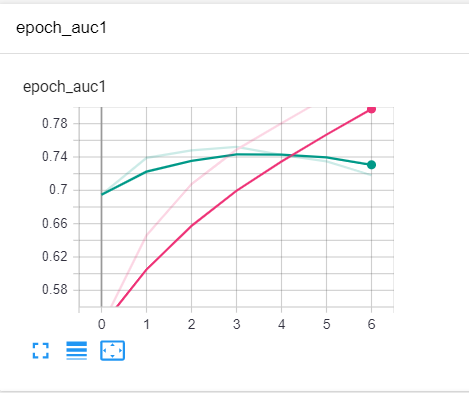

In [5]:
Image.open("model_3_1.png")

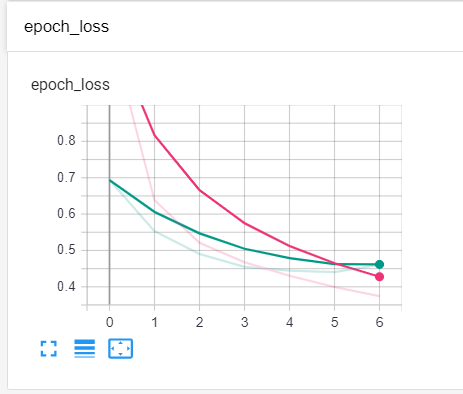

In [6]:
Image.open("model_3_2.png")

In this model we used Convolution layer. The model take less time to reach AUC score of 75. Using the Convolution layer reduced the training time while keeping the same performance. Model does started overfitting, but this can be avoided by introducing more data. 